# Problem Statement

 Cassava leaf disease classification is the process of identifying and categorizing the various diseases that can affect the leaves of the cassava plant. This is important for effective disease management and the preservation of cassava yields. The diseases are typically classified based on symptoms, causative agents (such as fungi, viruses, or bacteria), and mode of transmission. Examples of common cassava leaf diseases include cassava mosaic disease, cassava bacterial blight, and cassava brown streak disease. 

 This project uses artificial intelligence to detect and classify cassava leaf diseases. Problem statement and datasets can be found here: https://www.kaggle.com/c/cassava-leaf-disease-classification 
 

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import os,json
from tqdm.notebook import tqdm
from pathlib import Path
import imagehash
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB3, EfficientNetB4
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout
from tensorflow.keras.layers import  GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.losses import Loss

# Import libraries for reading images and plotting
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [3]:
# Directory path
dir_path = '/kaggle/input/cassava-leaf-disease-classification/'

# Read the CSV file into a pandas DataFrame
train_df = pd.read_csv(dir_path + 'train.csv')

# Display the train set
display(train_df)

# Display information about the train set
train_df.info()

image_id  label
0      1000015157.jpg      0
1      1000201771.jpg      3
2       100042118.jpg      1
3      1000723321.jpg      1
4      1000812911.jpg      3
...               ...    ...
21392   999068805.jpg      3
21393   999329392.jpg      3
21394   999474432.jpg      1
21395   999616605.jpg      4
21396   999998473.jpg      4

[21397 rows x 2 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


classes =  {
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
} 

                            class_name  count
0       Cassava Bacterial Blight (CBB)   1087
1  Cassava Brown Streak Disease (CBSD)   2189
2           Cassava Green Mottle (CGM)   2386
3         Cassava Mosaic Disease (CMD)  13158
4                              Healthy   2577 



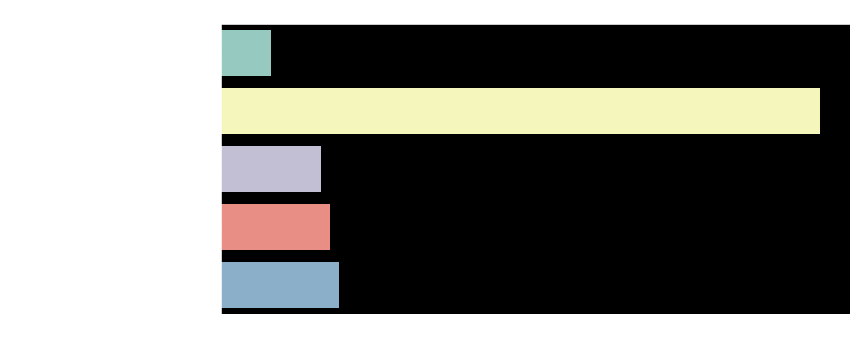

In [4]:
# Load and print the classes 
with open(dir_path + "label_num_to_disease_map.json") as f:
    classes = json.load(f)     
print('classes = ', json.dumps(classes, indent=4), '\n')  

# Map labels to their classes   
train_df['class_name'] = train_df['label'].map(lambda x: classes[str(x)])

# Count number of samples in each class
label_count = train_df.groupby(['class_name'])['class_name'].count().reset_index(name='count')
print(label_count, '\n')

# Create a countplot for the number of samples in each class
plt.figure(figsize=(12,5))
plt.style.use('dark_background')
ax = sns.countplot(data=train_df, y='class_name')
ax.set_title('Number of samples in each class', size=15)
plt.tight_layout()
plt.show()

In [5]:
classes = train_df['class_name'].value_counts().index
values = train_df['class_name'].value_counts().values

fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type": "xy"}, {"type": "domain"}]],
                    subplot_titles=('Distribution of Classes',
                                    'Proportion of classes'))

# Create a barchart
ax1 = go.Bar(x=classes, y=values, text= values,
            textposition='auto',name='Count',
             marker_color='darkgreen')

# Create a piechart
ax2 = go.Pie(labels=classes, values=values, hole=0.3)
fig.add_trace(ax1,row=1, col=1)
fig.add_trace(ax2,row=1, col=2)
fig.show()

 ##### Let's visualize a few pictures from each class. #####

In [6]:
 # Create a function to read and display images
def show_images(class_label):
    one_class_df = train_df[train_df.label==class_label].reset_index(drop=True)
    plt.figure(figsize=(14,14))
    for i in range(10):
        img = train_images + one_class_df.loc[i,'image_id']
        img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
        plt.subplot(5,5,i+1)
        plt.imshow(img)
        plt.suptitle(one_class_df.loc[i,'class_name'], y=1.04, fontsize=18)
        plt.axis("off")
    plt.tight_layout()

In [7]:
train_images = dir_path + 'train_images/'

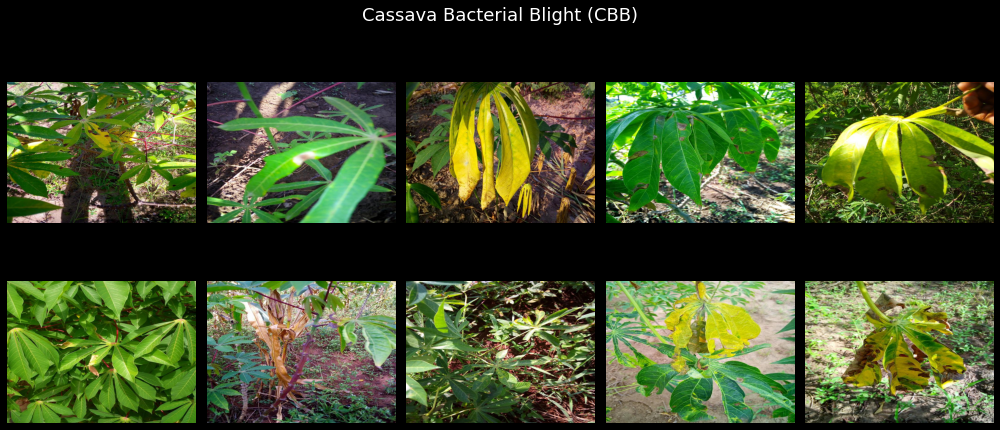

In [8]:
# Display 10 images from cassava bacterial blight disease
show_images(0)

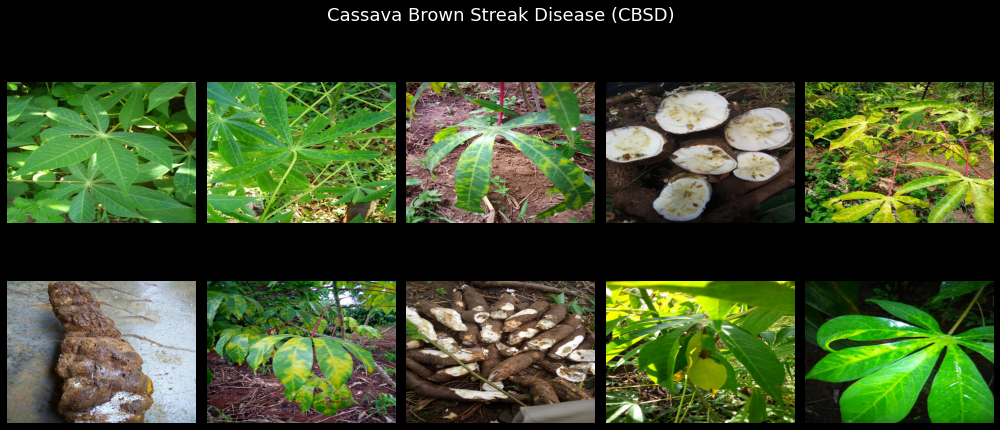

In [9]:
# Display 10 images from cassava brown streak disease
show_images(1)

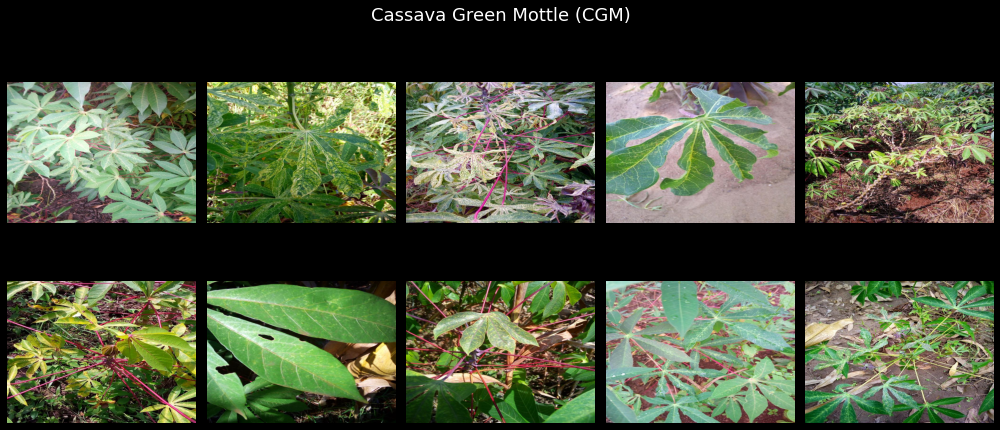

In [10]:
# Display 10 images from cassava green mottle disease
show_images(2)

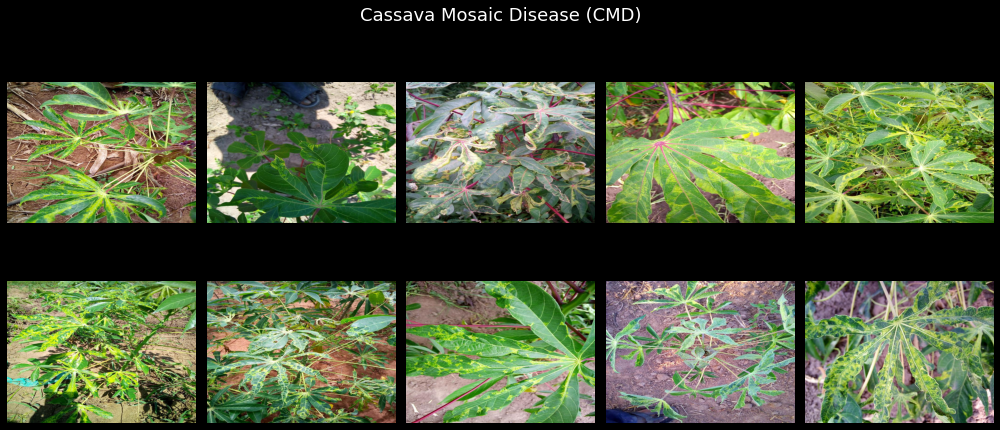

In [11]:
# Display 10 images from cassava mosaic disease
show_images(3)

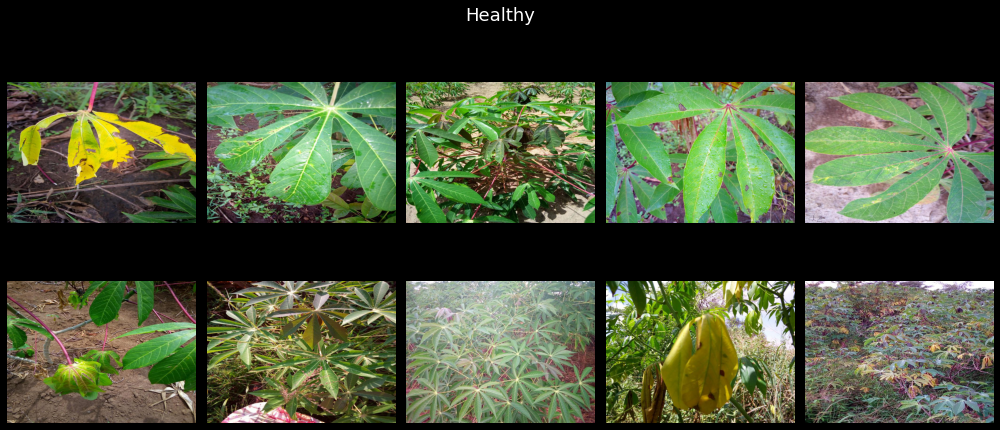

In [12]:
# Display 10 images from healthy cassava leaves
show_images(4)

In [13]:
sample_image = train_images + train_df.loc[0,'image_id']
print('image dimensions = ',np.shape(cv2.imread(sample_image)))

image dimensions =  (600, 800, 3)


Some images in some classes appear to look significantly different from the rest of the class. We can detect the potential outliers by using the median of the images in each class.

First, the statistical quantities (median) of each image in each class are added to a dictionary. 

### The reason behind using median instead of mean: ###
There are normal images with very bright or dark backgrounds and hence their array include more extreme color intensities compared to other images. Therefore, the mean of these images might be significantly different from other images and this could lead to a wrong conclusion that they are outliers. To avoid this problem we can use the median of images. Median is a robust statistical measure which is less sensitve to the significant changes in the background. 

In [9]:
image_stats = {class_name: [] for class_name in classes}

for class_name in tqdm(classes):
    new_df = train_df[train_df.class_name==class_name]
    for idx in tqdm(new_df.index):
        img = train_images + new_df.loc[idx,'image_id']
        
        # Read and normalize the image
        img = cv2.imread(img)
        img = cv2.normalize(img, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
        # Store the index of the image and the median of each channel
        image_stats[class_name].append([np.median(img[:,:,0]),
                                        np.median(img[:,:,1]),
                                        np.median(img[:,:,2]),
                                        idx])

I have stored the median of each channel separately. The below scatterplots and boxplots are created for each class and channel.

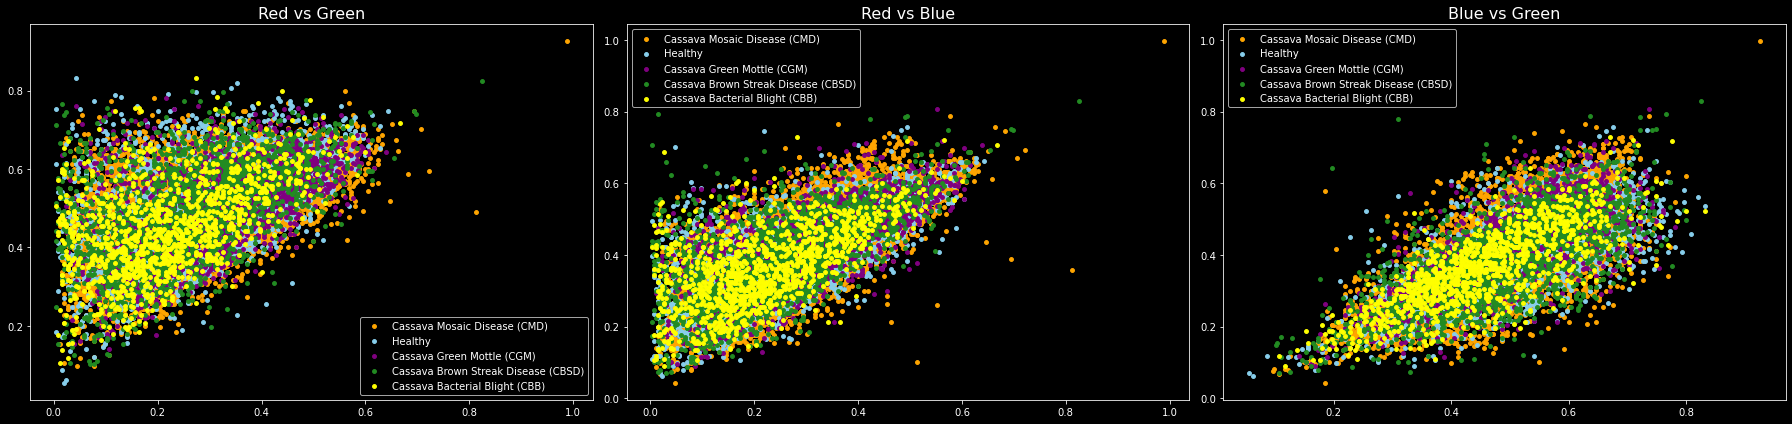

In [11]:
colors = ['orange', 'skyblue', 'purple', 'forestgreen', 'yellow']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 6))
for i, class_name in enumerate(classes):
    reds, greens, blues = [], [], []
    for stats in image_stats[class_name]:
        reds.append(stats[0])
        greens.append(stats[1])
        blues.append(stats[2])
    ax1.scatter(reds, greens, color=colors[i], label=class_name, s=15)
    ax2.scatter(reds, blues, color=colors[i], label=class_name, s=15)
    ax3.scatter(greens, blues, color=colors[i], label=class_name, s=15)

ax1.set_title('Red vs Green', size=16)
ax2.set_title('Red vs Blue', size=16)
ax3.set_title('Blue vs Green', size=16)
ax1.legend()
ax2.legend()
ax3.legend()

plt.tight_layout()
plt.show()

The scatter plots show the presence of more extreme images in CMD (orange dots) and CBSD classes (green dots). Next plots provide more information specially for CBSD class where we can see that there exist some images from the roots of the cassava plant (which look like potatoes!).

Also, from the plots it can be seen that the CBB class (yellow dots) is less variant compared to other classes.

In [12]:
def plot_medians(classes, image_stats):
    median0, median1, median2 = [], [], []
    for class_name in classes:
        n = len(image_stats[class_name])
        median0.append([image_stats[class_name][i][0] for i in range(n)])
        median1.append([image_stats[class_name][i][1] for i in range(n)])
        median2.append([image_stats[class_name][i][2] for i in range(n)])

    fig, ax = plt.subplots(3, figsize=(14,10))
    bp1 = ax[0].boxplot(median0, patch_artist=True, notch=True, labels=classes)
    bp2 = ax[1].boxplot(median1, patch_artist=True, notch=True, labels=classes)
    bp3 = ax[2].boxplot(median2, patch_artist=True, notch=True, labels=classes)

    colors = ['pink', 'lightblue', 'lightgreen', 'orange', 'grey']
    for bp in [bp1, bp2, bp3]:
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

    ax[0].set_title('Median of the red channel', size=14)
    ax[1].set_title('Median of the green channel', size=14)
    ax[2].set_title('Median of the blue channel', size=14)
    plt.style.use('default')
    plt.tight_layout()
    plt.show()

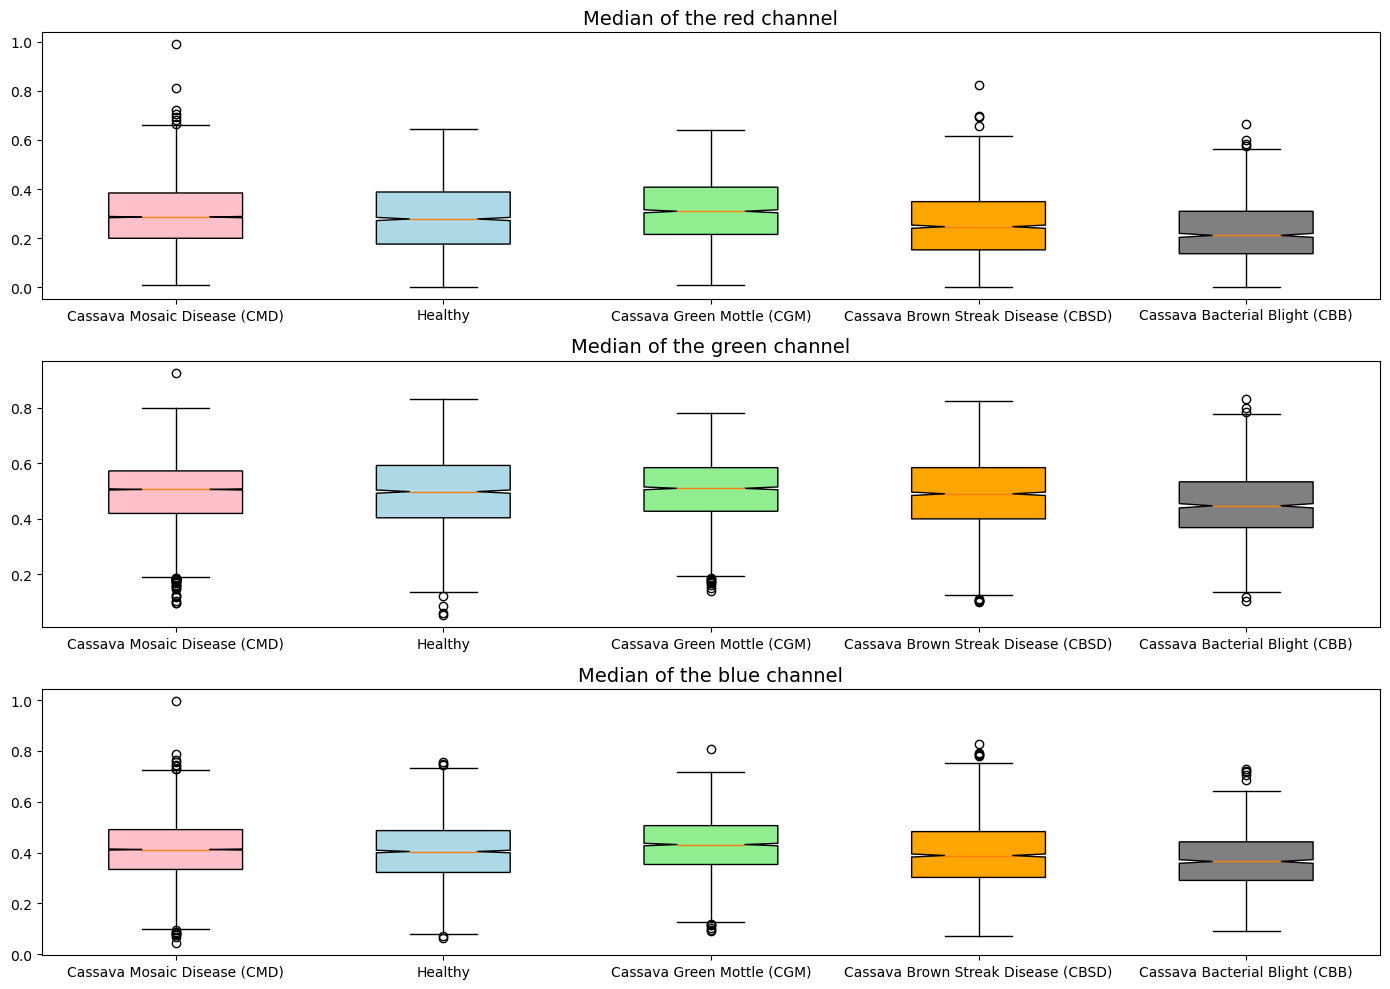

In [14]:
plot_medians(classes, image_stats)

In [16]:
def detect_outliers(class_name,p1,p2):
    def IQR(X):
        q1, q2 = np.percentile(X,[p1,p2])
        iqr = q2 - q1
        lower_bound  = q1 - (1.5 * iqr) 
        upper_bound = q2 + (1.5 * iqr)
        return np.where((X > upper_bound) | (X < lower_bound))[0]

    outliers = []
    n = len(image_stats[class_name])
    median0 = [image_stats[class_name][i][0] for i in range(n)]
    median1 = [image_stats[class_name][i][1] for i in range(n)]
    median2 = [image_stats[class_name][i][2] for i in range(n)]

    outlier_idx = np.union1d(IQR(median0), np.union1d(IQR(median1), IQR(median2)))
    for idx in outlier_idx:
        index_outlier_df = image_stats[class_name][idx][3]
        outliers.append(index_outlier_df)
    return outliers


def plot_outliers(outliers):
    plt.figure(figsize=(20,15))
    plt.style.use('dark_background')
    for i, idx in enumerate(outliers):
        outlier_img = train_images + train_df.loc[idx,'image_id']
        outlier_img = cv2.cvtColor(cv2.imread(outlier_img), cv2.COLOR_BGR2RGB)
        plt.subplot(10,10,i+1)
        plt.imshow(outlier_img)
        plt.axis('off')

In the above functions, we can modify the inter-quartile range for each class separately to detect the outliers. Fo example, setting the lower and upper percentiles to $20$ and $80$ respectively, we obtain the following images whose statistical quantities fall outside of the range in the IQR function.

The potential outliers for Cassava Mosaic Disease (CMD) are shown below.

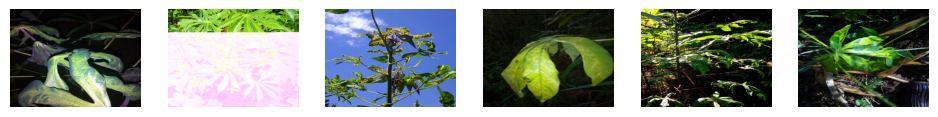

In [17]:
# Potential outliers for cassava mosaic disease
outliers = detect_outliers("Cassava Mosaic Disease (CMD)",20, 80)
plot_outliers(outliers)

The potential outliers for healthy leaves are shown below. For the remaining classes I have used $25$ and $75$ percentiles.

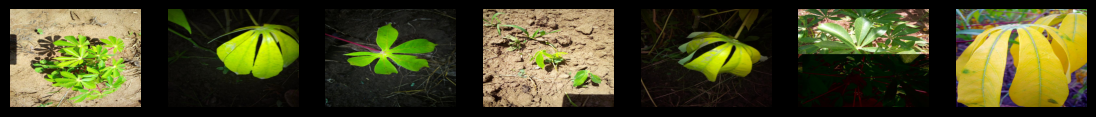

In [18]:
# Potential outliers for healthy leaves
outliers = detect_outliers("Healthy", 25, 75)
plot_outliers(outliers)

It looks like some images maybe wrongly labeled to the healthy class. However, just because a leaf is yellow doesn't mean it has a disease.

The potential outliers for Cassava Green Mottle (CGM) are shown below.

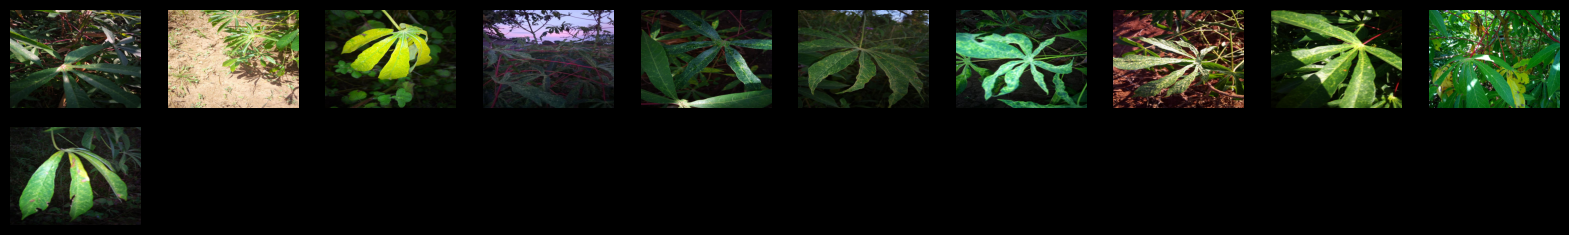

In [19]:
# The potential outliers for cassava green mottle 
outliers = detect_outliers("Cassava Green Mottle (CGM)", 25, 75)
plot_outliers(outliers)

The potential outliers for Cassava Brown Streak Disease (CBSD) are shown below.

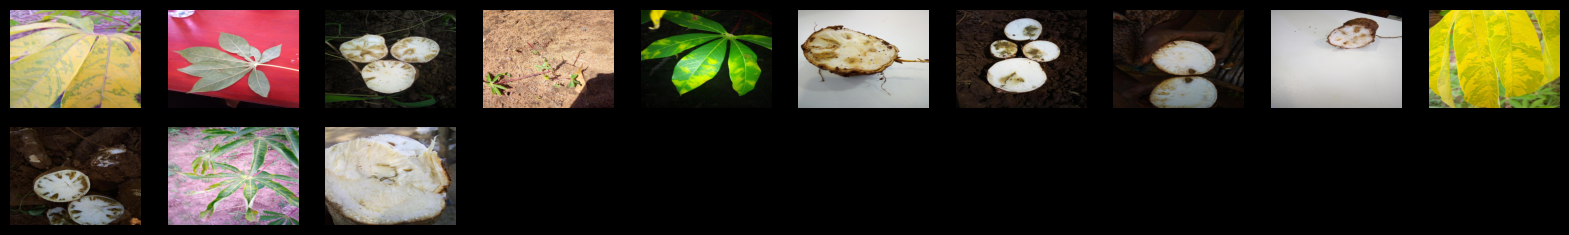

In [20]:
# Potential outliers for Cassava Brown Streak Disease (CBSD)
outliers = detect_outliers("Cassava Brown Streak Disease (CBSD)", 25, 75)
plot_outliers(outliers)

The CBSD dataset contains two types of images: one showing the plant or leaves and the other showing the roots, which may be mistaken for potatoes or noise. But all of these images could be related to the CBSD disease.

The potential outliers for Cassava Bacterial Blight (CBB) are shown below.

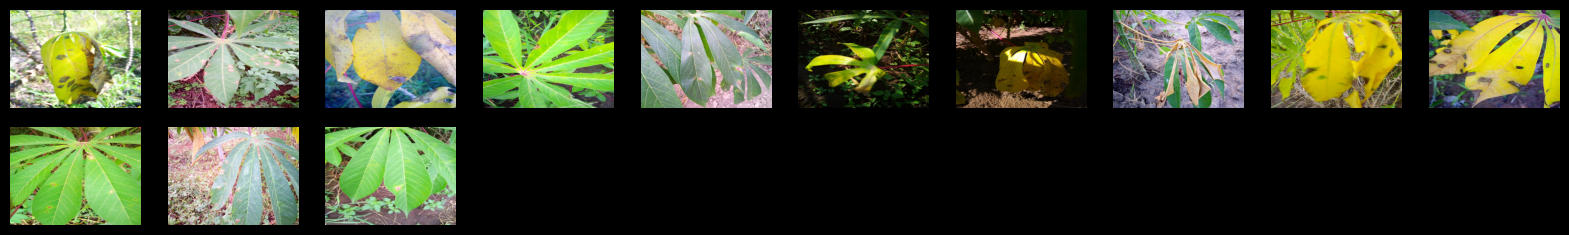

In [21]:
# Potential outliers for Cassava Bacterial Blight (CBB)
outliers = detect_outliers("Cassava Bacterial Blight (CBB)", 25, 75)
plot_outliers(outliers)



The above images all belong to the cassava plant and related to the dataset for classifying the diseases. Their statistics are unusual due to some reasons such as the background color, distance, daylight, presence of human or possible wrong labels, etc.

The technique of developing new training examples from the ones that already exist is known as image augmentation. We gently alter the original image to create a new sample. For instance, you may chop a portion from the original image, produce a new image by mirroring the original one, or make the new image a little brighter.

 We can import and augment the data using ImageDataGenerator.

In [22]:
# Drop the last column, i.e. class_name
train_df.pop('class_name')

# labels
y = train_df['label']

# Convert labels to strings
train_df.label = train_df.label.astype('str')

TARGET_SIZE = 256
BATCH_SIZE = 32

# Split the dataset and keep the proportion of labels through the training and validation sets
xtrain, xvalid, ytrain, yvalid = train_test_split(train_df, y, test_size = 0.1, random_state = 42, stratify=y)


datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 45,
                    shear_range = 0.1,
                    zoom_range = 0.2,
                    width_shift_range = 0.,
                    height_shift_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

datagen_validation = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

train_generator = datagen_train.flow_from_dataframe(xtrain,
                             directory = train_images,
                             target_size = (TARGET_SIZE,TARGET_SIZE),
                             x_col = 'image_id',
                             y_col = 'label',
                             class_mode = 'sparse',
                             interpolation = 'nearest',
                             batch_size = BATCH_SIZE,
                             shuffle = True)

validation_generator = datagen_validation.flow_from_dataframe(xvalid,
                             directory = train_images,
                             target_size = (TARGET_SIZE,TARGET_SIZE),
                             x_col = 'image_id',
                             y_col = 'label',
                             class_mode = 'sparse',
                             interpolation = 'nearest',
                             batch_size = BATCH_SIZE,
                             shuffle = True)


Found 19257 validated image filenames belonging to 5 classes.
Found 2140 validated image filenames belonging to 5 classes.


##### We can see that the proportion of classes is the same for the train set and validation set. #####

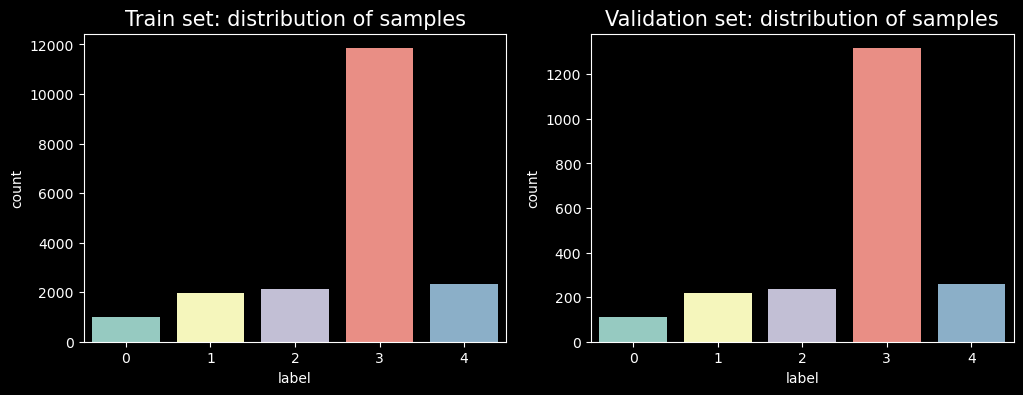

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(data=xtrain, x='label', ax=ax[0])
ax[0].set_title('Train set: distribution of samples', size=15)
sns.countplot(data=xvalid, x='label', ax=ax[1])
ax[1].set_title('Validation set: distribution of samples', size=15)
plt.style.use('dark_background')
plt.show()

##### Let's visualize a few augmented images. #####

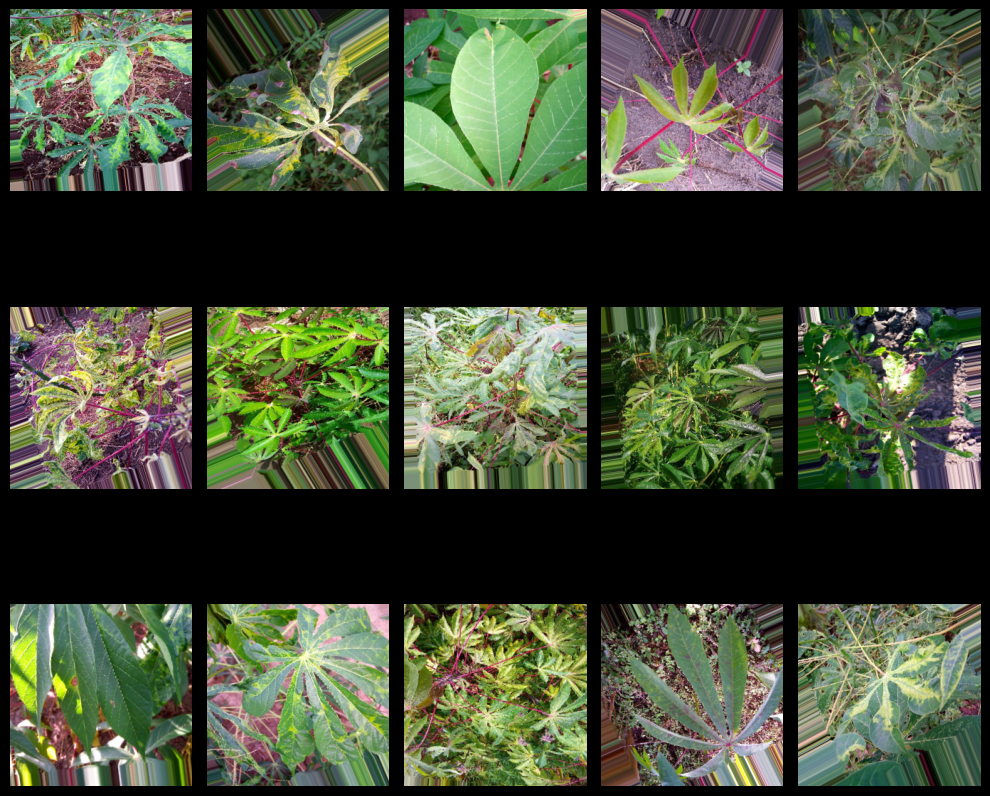

In [42]:
images = [train_generator[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3,5, figsize=(10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(TARGET_SIZE, TARGET_SIZE, 3)/255)
    ax.axis('off')

plt.tight_layout()
plt.show()

For training, I have used a pre-trained EfficientNetB4 model. The weights are the 'imagenet' weights. These weights are trained for object classification. We use the already-trained initial layers which detects lower-level features like edges. We then replace the top layers with our own dense layers to recognize higher level features and this is the reason that we set the include_top parameter of the EfficientNet to False. 

This method is called Transfer Learning.

In [ ]:
class SimpleQuadraticDense(Layer):

    def __init__(self, units, activation):
        super().__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        a_init = tf.random_normal_initializer()
        self.a = tf.Variable(name='kernel', initial_value=a_init(shape=(input_shape[-1], self.units)),
                          trainable=True)
      
        b_init = tf.random_normal_initializer()
        self.b = tf.Variable(name='kernel', initial_value=b_init(shape=(input_shape[-1], self.units)),
                          trainable=True)
      
        c_init = tf.zeros_initializer()
        self.c = tf.Variable(name='bias', initial_value=c_init(shape=(self.units,)),
                           trainable=True)
      
    def call(self, inputs):
        return self.activation(tf.matmul(inputs**2, self.a) + tf.matmul(inputs, self.b) + self.c)
      

 ##### Submissions will be evaluated based on their categorization accuracy. #####

In [27]:
def build_model(num_classes):
    
    model = Sequential()
    
    # Load the pretrained EfficientNetB4 model
    EfficientNet = tf.keras.applications.EfficientNetB4(input_shape=(TARGET_SIZE, TARGET_SIZE, 3),
                                                        include_top=False,
                                                        weights='imagenet')
    
    model.add(EfficientNet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    optimizer = tf.keras.optimizers.Adam(lr=1e-3)
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["acc"])
    
    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 8, 8, 1792)        17673823  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1792)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              1836032   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 5)                

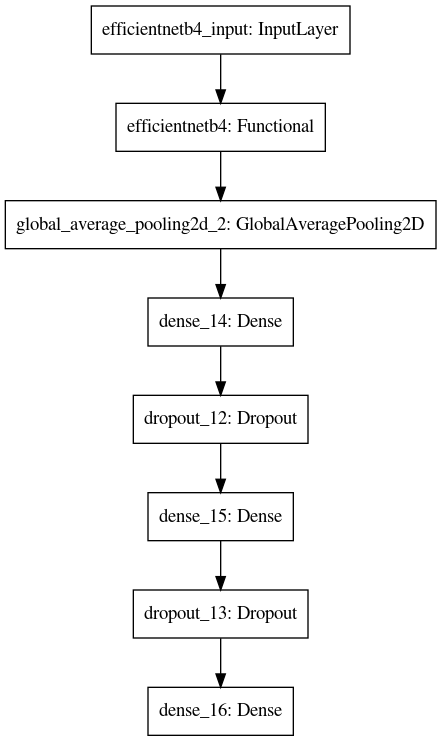

In [28]:
model = build_model(num_classes=5)
model.summary()
tf.keras.utils.plot_model(model)

In [30]:
model = build_model(num_classes=5)
    
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                            patience = 4)

checkpoint = tf.keras.callbacks.ModelCheckpoint("EB4_weights.h5",
                                                save_weights_only = True,
                                                monitor = 'val_accuracy', 
                                                mode ='max')   
    
BATCH_SIZE = 32
EPOCHS = 10

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [callback, checkpoint])

model.save('MyModel.h5')
model.save('./MyModel_tf',save_format='tf')

Epoch 1/10
601/601 [==============================] - 685s 1s/step - loss: 0.7000 - acc: 0.7559 - val_loss: 0.6219 - val_acc: 0.8092
Epoch 2/10
601/601 [==============================] - 676s 1s/step - loss: 0.5419 - acc: 0.8156 - val_loss: 0.5134 - val_acc: 0.8419
Epoch 3/10
601/601 [==============================] - 671s 1s/step - loss: 0.4954 - acc: 0.8351 - val_loss: 0.4555 - val_acc: 0.8423
Epoch 4/10
601/601 [==============================] - 669s 1s/step - loss: 0.4776 - acc: 0.8397 - val_loss: 0.5075 - val_acc: 0.8466
Epoch 5/10
601/601 [==============================] - 659s 1s/step - loss: 0.4502 - acc: 0.8494 - val_loss: 0.4778 - val_acc: 0.8475
Epoch 6/10
601/601 [==============================] - 641s 1s/step - loss: 0.4324 - acc: 0.8557 - val_loss: 0.4332 - val_acc: 0.8580
Epoch 7/10
601/601 [==============================] - 644s 1s/step - loss: 0.4263 - acc: 0.8571 - val_loss: 0.4468 - val_acc: 0.8475
Epoch 8/10
601/601 [==============================] - 631s 1s/step - 

In [ ]:
model = build_model(num_classes=5)
model.load_weights('EB3_weights.h5')
model.evaluate(validation_generator)

#### Finally I make predictions on the test set using the saved model. ####

In [34]:
from PIL import Image

test_dir = dir_path + 'test_images/'
test_images = os.listdir(test_dir)
predictions = []

for image in test_images:
    img = test_dir + image
    img = Image.open(img)
    img = img.resize((256, 256))
    img = np.expand_dims(img, axis=0)
    predictions.extend(model.predict(img).argmax(axis=1))
    
submission = pd.DataFrame({'image_id': test_images, 'label': predictions})
submission.to_csv('submission.csv', index = False)